Пропущенные значения в train (доля пропусков):
LotFrontage     0.178938
Alley           0.939212
MasVnrType      0.594178
MasVnrArea      0.006849
BsmtQual        0.022260
BsmtCond        0.022260
BsmtExposure    0.023116
BsmtFinType1    0.022260
BsmtFinType2    0.023116
Electrical      0.000856
FireplaceQu     0.468322
GarageType      0.056507
GarageYrBlt     0.056507
GarageFinish    0.056507
GarageQual      0.056507
GarageCond      0.056507
PoolQC          0.994007
Fence           0.816781
MiscFeature     0.963185
dtype: float64
Пропущенные значения в test (доля пропусков):
LotFrontage     0.171233
Alley           0.931507
MasVnrType      0.609589
BsmtQual        0.037671
BsmtCond        0.037671
BsmtExposure    0.037671
BsmtFinType1    0.037671
BsmtFinType2    0.037671
FireplaceQu     0.489726
GarageType      0.051370
GarageYrBlt     0.051370
GarageFinish    0.051370
GarageQual      0.051370
GarageCond      0.051370
PoolQC          1.000000
Fence           0.770548
MiscFeature     0

C:\Users\Faste\AppData\Roaming\Python\Python310\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Multicollinearity analysis:
        Feature           VIF
36     1stFlrSF           inf
37     2ndFlrSF           inf
38    GrLivArea           inf
31  TotalBsmtSF  1.310375e+04
30    BsmtUnfSF  1.011271e+04
..          ...           ...
5        Street  1.237273e+00
11   Condition1  1.219159e+00
58       YrSold  1.167706e+00
57       MoSold  1.153362e+00
0            Id  1.131011e+00

[61 rows x 2 columns]
Пропущенные значения в train (доля пропусков):
LotFrontage     0.178938
Alley           0.939212
MasVnrType      0.594178
MasVnrArea      0.006849
BsmtQual        0.022260
BsmtCond        0.022260
BsmtExposure    0.023116
BsmtFinType1    0.022260
BsmtFinType2    0.023116
Electrical      0.000856
FireplaceQu     0.468322
GarageType      0.056507
GarageYrBlt     0.056507
GarageFinish    0.056507
GarageQual      0.056507
GarageCond      0.056507
PoolQC          0.994007
Fence           0.816781
MiscFeature     0.963185
dtype: float64
Пропущенные значения в test (доля пропусков):
LotFro

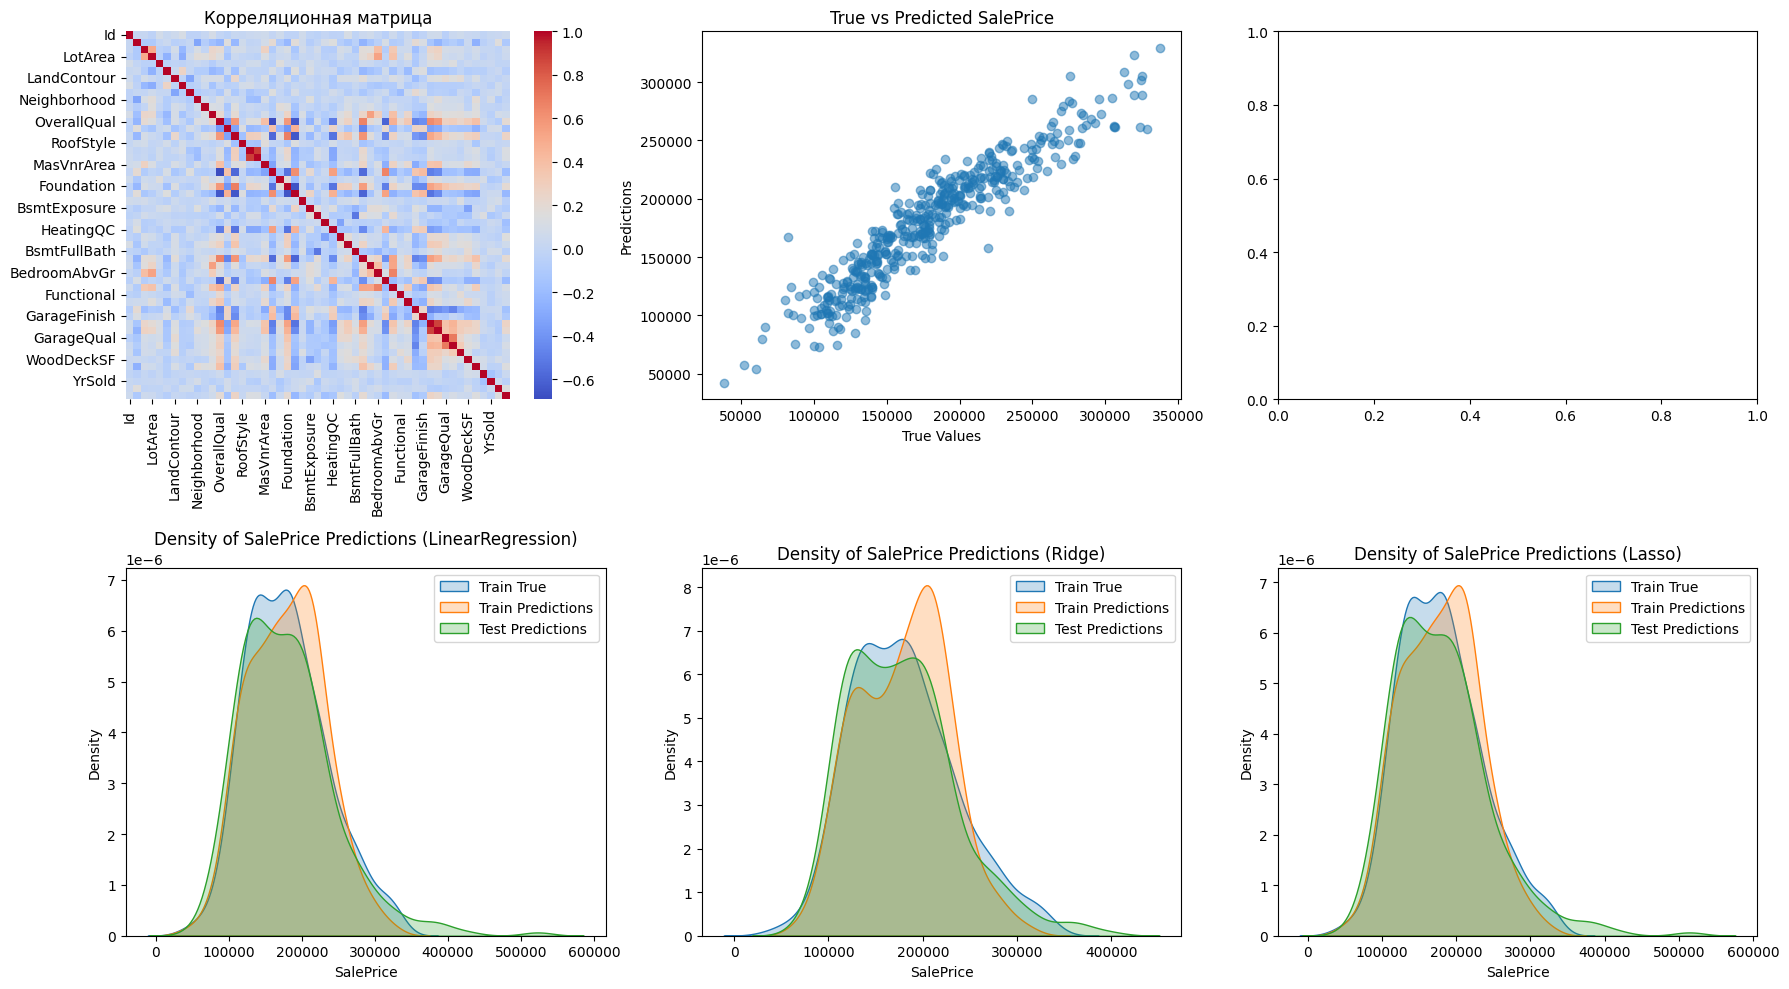

In [5]:
# V1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

trainDf = pd.read_csv('train_hw.csv')
testDf = pd.read_csv('test_hw.csv')

missingTrain = trainDf.isnull().mean()
missingTest = testDf.isnull().mean()

print("Пропущенные значения в train (доля пропусков):")
print(missingTrain[missingTrain > 0])
print("Пропущенные значения в test (доля пропусков):")
print(missingTest[missingTest > 0])

threshold = 0.3
highMissingCols = missingTrain[missingTrain > threshold].index
trainDf.drop(columns=highMissingCols, inplace=True)
testDf.drop(columns=highMissingCols, inplace=True)

numCols = trainDf.select_dtypes(exclude=['object']).columns
catCols = trainDf.select_dtypes(include=['object']).columns
testNumcols = testDf.select_dtypes(exclude=['object']).columns

trainDf[numCols] = trainDf[numCols].fillna(trainDf[numCols].median())
testDf[testNumcols] = testDf[testNumcols].fillna(testDf[testNumcols].median())

trainDf[catCols] = trainDf[catCols].fillna('Missing')
testDf[catCols] = testDf[catCols].fillna('Missing')

Q1 = trainDf[numCols].quantile(0.25)
Q3 = trainDf[numCols].quantile(0.75)
IQR = Q3 - Q1
trainDf = trainDf[~((trainDf[numCols] < (Q1 - 1.5 * IQR)) | (trainDf[numCols] > (Q3 + 1.5 * IQR))).any(axis=1)]

for col in catCols:
    le = LabelEncoder()
    le.fit(pd.concat([trainDf[col], testDf[col]], axis=0))
    trainDf[col] = le.transform(trainDf[col])
    testDf[col] = le.transform(testDf[col])

Xtrain = trainDf.drop(columns=['SalePrice'])
Ytrain = trainDf['SalePrice']
Xtest = testDf.drop(columns=['SalePrice'], errors='ignore')

constantCols = Xtrain.columns[Xtrain.nunique() == 1]
print("Константные признаки после удаления выбросов:", constantCols.tolist())
Xtrain.drop(columns=constantCols, inplace=True)
Xtest.drop(columns=constantCols, inplace=True)

scaler = MinMaxScaler()
Xtrain[Xtrain.columns] = scaler.fit_transform(Xtrain[Xtrain.columns])
Xtest[Xtrain.columns] = scaler.transform(Xtest[Xtrain.columns])

vifData = pd.DataFrame()
vifData["Feature"] = Xtrain.columns
vifData["VIF"] = [variance_inflation_factor(Xtrain.values.astype(float), i) for i in range(Xtrain.shape[1])]

print("Multicollinearity analysis:")
print(vifData.sort_values(by="VIF", ascending=False))

highVifFeatures = vifData[vifData["VIF"] > 10]["Feature"].tolist()
Xtrain.drop(columns=highVifFeatures, inplace=True)
Xtest.drop(columns=highVifFeatures, inplace=True, errors='ignore')

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.heatmap(Xtrain.corr(), cmap='coolwarm', annot=False, ax=axes[0, 0])
axes[0, 0].set_title('Корреляционная матрица')

print("Пропущенные значения в train (доля пропусков):")
print(missingTrain[missingTrain > 0])
print("Пропущенные значения в test (доля пропусков):")
print(missingTest[missingTest > 0])

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=10),
    "Lasso": Lasso(alpha=10)
}

for i, (name, model) in enumerate(models.items()):
    model.fit(Xtrain, Ytrain)
    YtrainPred = model.predict(Xtrain)
    YtestPred = model.predict(Xtest)

    trainRmse = np.sqrt(mean_squared_error(Ytrain, YtrainPred))
    print(f'RMSE ({name}) на тренировочном наборе: {trainRmse}')

    sns.kdeplot(Ytrain, label='Train True', fill=True, ax=axes[1, i])
    sns.kdeplot(YtrainPred, label='Train Predictions', fill=True, ax=axes[1, i])
    sns.kdeplot(YtestPred, label='Test Predictions', fill=True, ax=axes[1, i])
    axes[1, i].set_title(f'Density of SalePrice Predictions ({name})')
    axes[1, i].legend()

    if name == "Lasso":
        axes[0, 1].scatter(Ytrain, YtrainPred, alpha=0.5)
        axes[0, 1].set_xlabel('True Values')
        axes[0, 1].set_ylabel('Predictions')
        axes[0, 1].set_title('True vs Predicted SalePrice')

        submission = pd.DataFrame({
            'Id': testDf['Id'],
            'SalePrice': YtestPred
        })
        submission.to_csv('submission.csv', index=False)

plt.tight_layout()
plt.show()

Пропущенные значения в train (доля пропусков):
LotFrontage     0.178938
Alley           0.939212
MasVnrType      0.594178
MasVnrArea      0.006849
BsmtQual        0.022260
BsmtCond        0.022260
BsmtExposure    0.023116
BsmtFinType1    0.022260
BsmtFinType2    0.023116
Electrical      0.000856
FireplaceQu     0.468322
GarageType      0.056507
GarageYrBlt     0.056507
GarageFinish    0.056507
GarageQual      0.056507
GarageCond      0.056507
PoolQC          0.994007
Fence           0.816781
MiscFeature     0.963185
dtype: float64
Пропущенные значения в test (доля пропусков):
LotFrontage     0.171233
Alley           0.931507
MasVnrType      0.609589
BsmtQual        0.037671
BsmtCond        0.037671
BsmtExposure    0.037671
BsmtFinType1    0.037671
BsmtFinType2    0.037671
FireplaceQu     0.489726
GarageType      0.051370
GarageYrBlt     0.051370
GarageFinish    0.051370
GarageQual      0.051370
GarageCond      0.051370
PoolQC          1.000000
Fence           0.770548
MiscFeature     0

c:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.873e+10, tolerance: 1.371e+08
  model = cd_fast.enet_coordinate_descent(


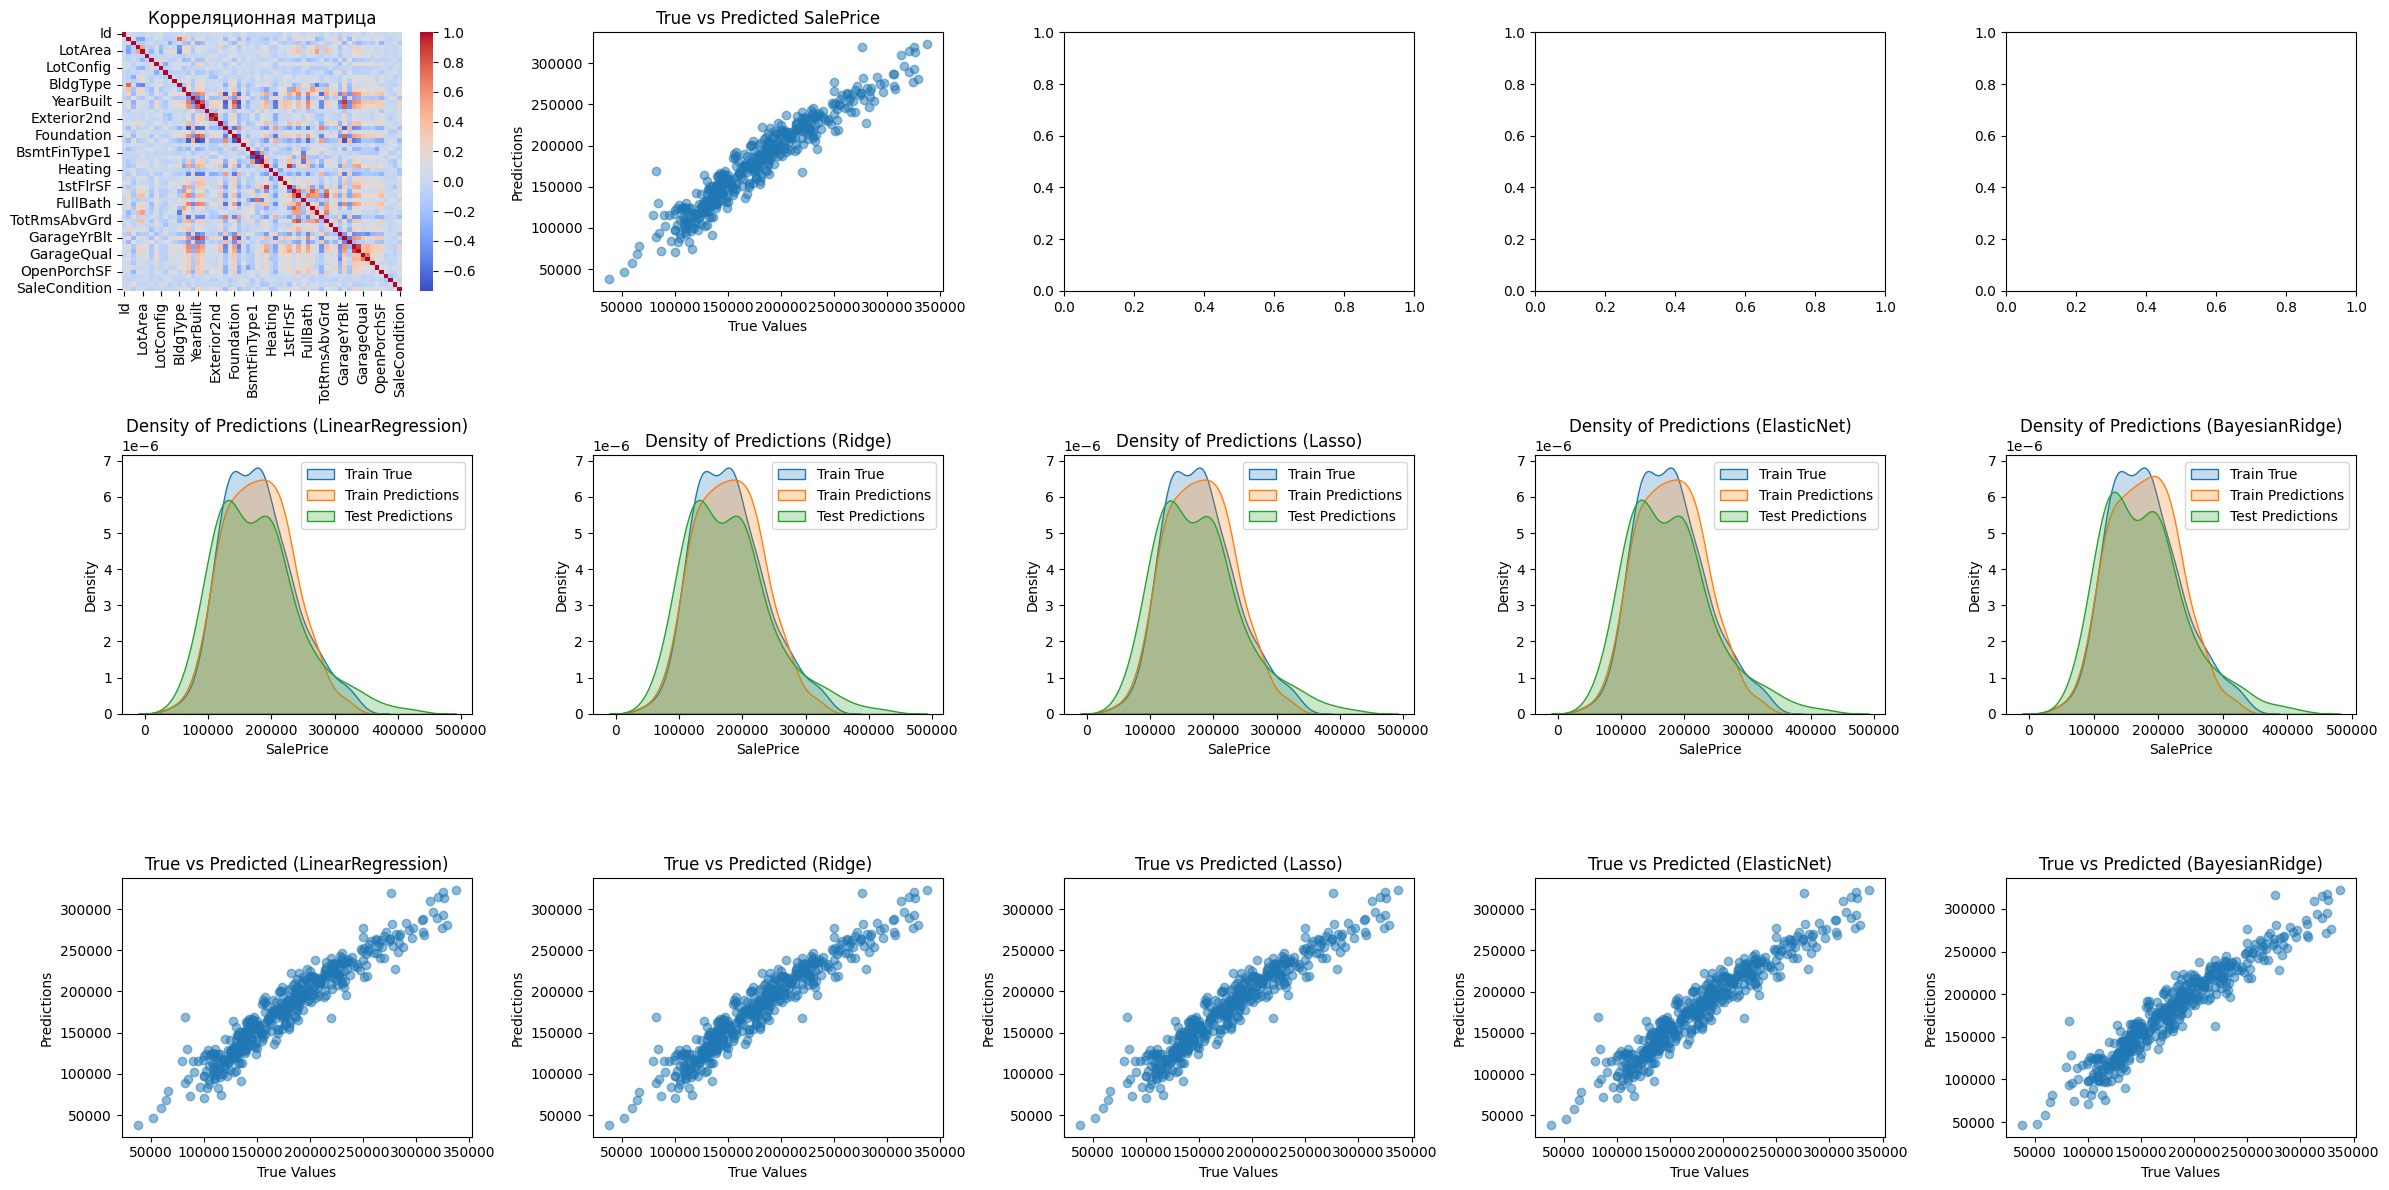

Лучшая модель: LinearRegression с RMSE 16192.69
Файл submission.csv сохранён.


In [ ]:
# V2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet, BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

trainDf = pd.read_csv('train_hw.csv')
testDf = pd.read_csv('test_hw.csv')

missingTrain = trainDf.isnull().mean()
missingTest = testDf.isnull().mean()

print("Пропущенные значения в train (доля пропусков):")
print(missingTrain[missingTrain > 0])
print("Пропущенные значения в test (доля пропусков):")
print(missingTest[missingTest > 0])

threshold = 0.3
highMissingCols = missingTrain[missingTrain > threshold].index
trainDf.drop(columns=highMissingCols, inplace=True)
testDf.drop(columns=highMissingCols, inplace=True)

numCols = trainDf.select_dtypes(exclude=['object']).columns
catCols = trainDf.select_dtypes(include=['object']).columns
testNumcols = testDf.select_dtypes(exclude=['object']).columns

trainDf[numCols] = trainDf[numCols].fillna(trainDf[numCols].median())
testDf[testNumcols] = testDf[testNumcols].fillna(testDf[testNumcols].median())

trainDf[catCols] = trainDf[catCols].fillna('Missing')
testDf[catCols] = testDf[catCols].fillna('Missing')

Q1 = trainDf[numCols].quantile(0.25)
Q3 = trainDf[numCols].quantile(0.75)
IQR = Q3 - Q1
trainDf = trainDf[~((trainDf[numCols] < (Q1 - 1.5 * IQR)) | (trainDf[numCols] > (Q3 + 1.5 * IQR))).any(axis=1)]

for col in catCols:
    le = LabelEncoder()
    le.fit(pd.concat([trainDf[col], testDf[col]], axis=0))
    trainDf[col] = le.transform(trainDf[col])
    testDf[col] = le.transform(testDf[col])

Xtrain = trainDf.drop(columns=['SalePrice'])
Ytrain = trainDf['SalePrice']
Xtest = testDf.drop(columns=['SalePrice'], errors='ignore')

constantCols = Xtrain.columns[Xtrain.nunique() == 1]
print("Константные признаки после удаления выбросов:", constantCols.tolist())
Xtrain.drop(columns=constantCols, inplace=True)
Xtest.drop(columns=constantCols, inplace=True)

scaler = MinMaxScaler()
Xtrain[Xtrain.columns] = scaler.fit_transform(Xtrain[Xtrain.columns])
Xtest[Xtrain.columns] = scaler.transform(Xtest[Xtrain.columns])

fig, axes = plt.subplots(3, 5, figsize=(24, 12))

sns.heatmap(Xtrain.corr(), cmap='coolwarm', annot=False, ax=axes[0, 0])
axes[0, 0].set_title('Корреляционная матрица')

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=0.0005),
    "Lasso": Lasso(alpha=0.0005),
    "ElasticNet": ElasticNet(alpha=0.0005, l1_ratio=0.9),
    "BayesianRidge": BayesianRidge()
}


results = {}
for i, (name, model) in enumerate(models.items()):
    model.fit(Xtrain, Ytrain)
    YtrainPred = model.predict(Xtrain)
    YtestPred = model.predict(Xtest)

    trainRmse = np.sqrt(mean_squared_error(Ytrain, YtrainPred))
    logRMSE = np.log1p(trainRmse)
    results[name] = trainRmse

    print(f'RMSE ({name}) на тренировочном наборе: {trainRmse:.2f} (log: {logRMSE:.2f})')

    sns.kdeplot(Ytrain, label='Train True', fill=True, ax=axes[1, i])
    sns.kdeplot(YtrainPred, label='Train Predictions', fill=True, ax=axes[1, i])
    sns.kdeplot(YtestPred, label='Test Predictions', fill=True, ax=axes[1, i])
    axes[1, i].set_title(f'Density of Predictions ({name})')
    axes[1, i].legend()

    axes[2, i].scatter(Ytrain, YtrainPred, alpha=0.5)
    axes[2, i].set_xlabel('True Values')
    axes[2, i].set_ylabel('Predictions')
    axes[2, i].set_title(f'True vs Predicted ({name})')

    if name == "LinearRegression":
        axes[0, 1].scatter(Ytrain, YtrainPred, alpha=0.5)
        axes[0, 1].set_xlabel('True Values')
        axes[0, 1].set_ylabel('Predictions')
        axes[0, 1].set_title('True vs Predicted SalePrice')

plt.tight_layout()
plt.show()

best_model = min(results, key=results.get)
print(f"Лучшая модель: {best_model} с RMSE {results[best_model]:.2f}")

finalModel = models[best_model]
finalModel.fit(Xtrain, Ytrain)
YtestPred = finalModel.predict(Xtest)

submission = pd.DataFrame({
    'Id': testDf['Id'],
    'SalePrice': YtestPred
})
submission.to_csv('submission.csv', index=False)
print("Файл submission.csv сохранён.")



Skew in numerical features: 

(1458, 222)

Linear Regression score: 0.1320 (0.0120)


Lasso Regression score: 0.1192 (0.0067)


Elastic Net score: 0.1193 (0.0070)


Ridge Regression score: 0.1344 (0.0071)


XGBoost Regressor score: 0.1457 (0.0108)

RMSE (Linear Regression) на тренировочном наборе: 18233.37 (log: 9.81)
RMSE (Lasso Regression) на тренировочном наборе: 20057.71 (log: 9.91)
RMSE (Elastic Net) на тренировочном наборе: 19925.48 (log: 9.90)
RMSE (Ridge Regression) на тренировочном наборе: 23897.93 (log: 10.08)
RMSE (XGBoost Regressor) на тренировочном наборе: 1406.56 (log: 7.25)


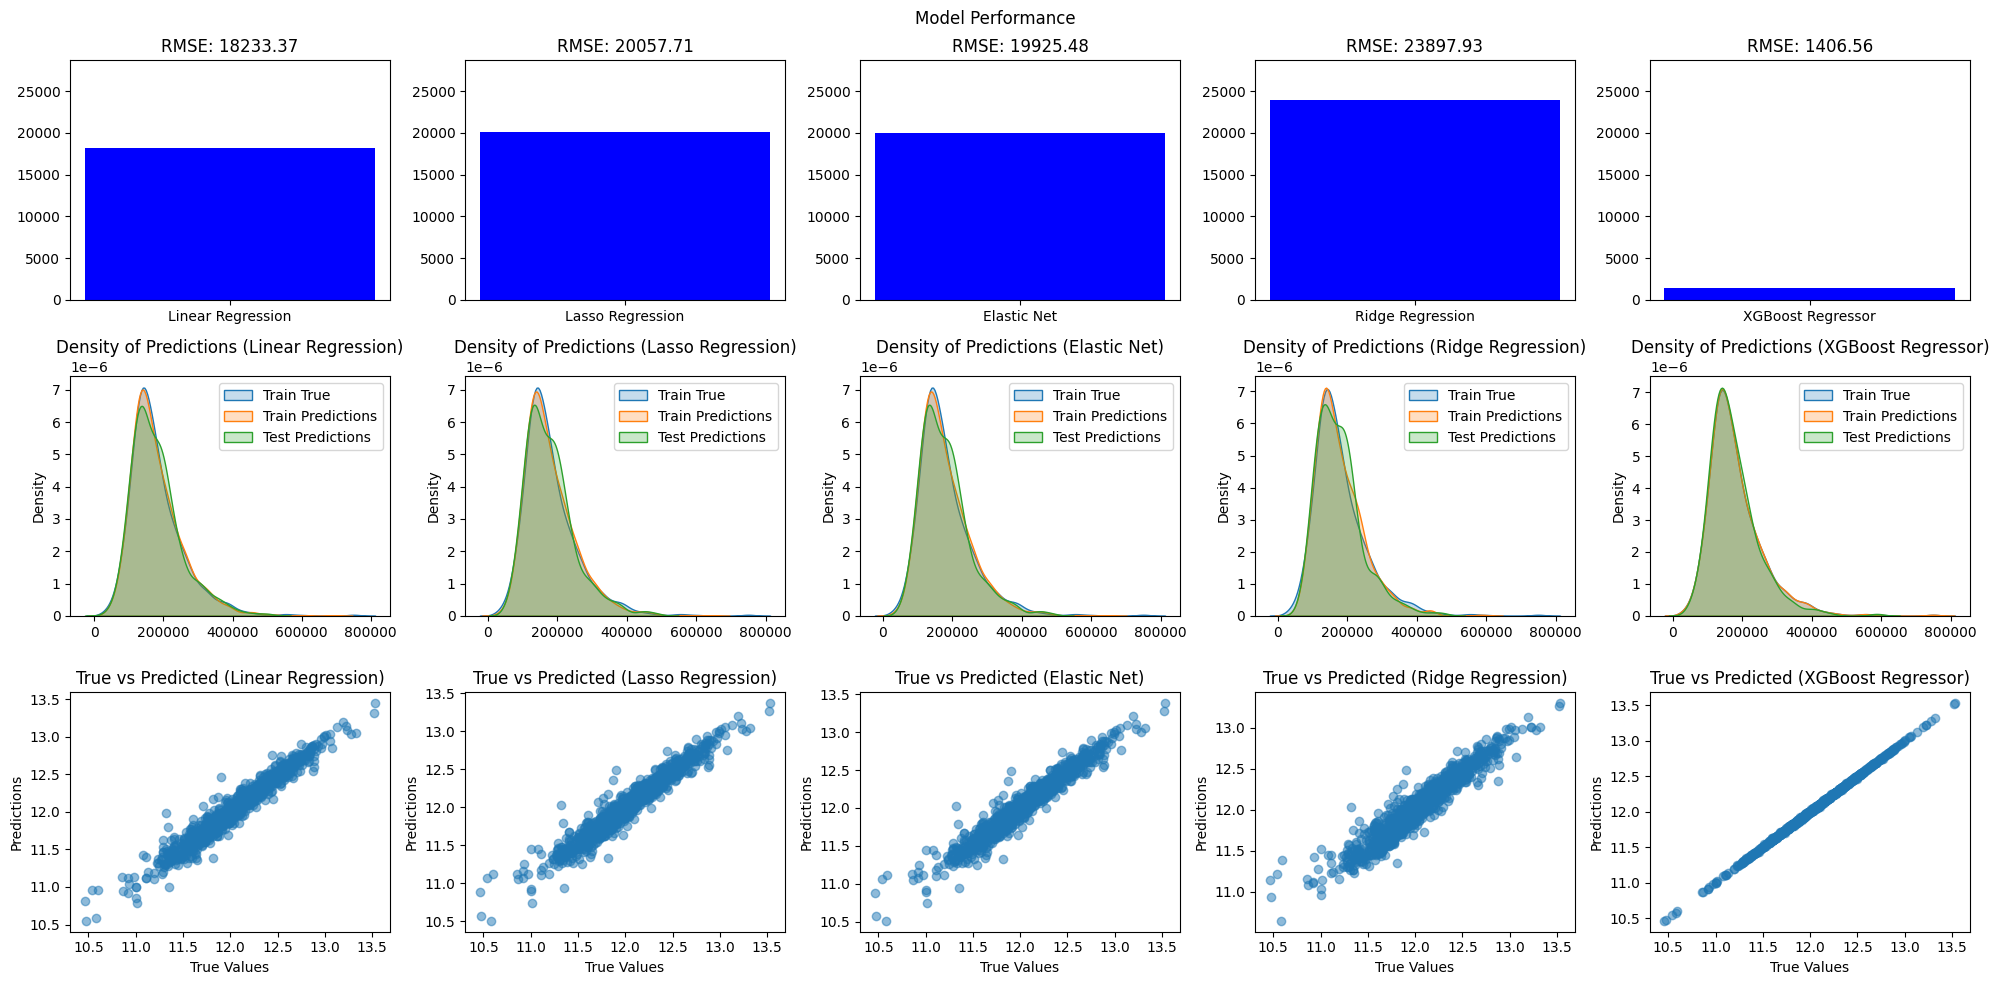

Лучший алгоритм: XGBoost Regressor с RMSE 1406.56
Файл submission.csv сохранён!


In [ ]:
# V3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet, BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from xgboost import XGBRegressor
from scipy.stats import skew

trainDf = pd.read_csv('train_hw.csv')
testDf = pd.read_csv('test_hw.csv')

trainID = trainDf['Id']
testID = testDf['Id']

trainDf.drop("Id", axis = 1, inplace = True)
testDf.drop("Id", axis = 1, inplace = True)

trainDf = trainDf.drop(trainDf[(trainDf['GrLivArea']>4000) & (trainDf['SalePrice']<300000)].index)

trainDf["SalePrice"] = np.log1p(trainDf["SalePrice"])

ntrain = trainDf.shape[0]
ntest = testDf.shape[0]
Ytrain = trainDf.SalePrice.values
allData = pd.concat((trainDf, testDf)).reset_index(drop=True)
allData.drop(['SalePrice'], axis=1, inplace=True)

allData["PoolQC"] = allData["PoolQC"].fillna("None")
allData["MiscFeature"] = allData["MiscFeature"].fillna("None")
allData["Alley"] = allData["Alley"].fillna("None")
allData["Fence"] = allData["Fence"].fillna("None")
allData["FireplaceQu"] = allData["FireplaceQu"].fillna("None")

allData["LotFrontage"] = allData.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    allData[col] = allData[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    allData[col] = allData[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    allData[col] = allData[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    allData[col] = allData[col].fillna('None')

allData = allData.drop(['Utilities'], axis=1)

allData["MasVnrType"] = allData["MasVnrType"].fillna("None")
allData["MasVnrArea"] = allData["MasVnrArea"].fillna(0)

allData['MSZoning'] = allData['MSZoning'].fillna(allData['MSZoning'].mode()[0])
allData["Functional"] = allData["Functional"].fillna("Typ")
allData['Electrical'] = allData['Electrical'].fillna(allData['Electrical'].mode()[0])
allData['KitchenQual'] = allData['KitchenQual'].fillna(allData['KitchenQual'].mode()[0])
allData['Exterior1st'] = allData['Exterior1st'].fillna(allData['Exterior1st'].mode()[0])
allData['Exterior2nd'] = allData['Exterior2nd'].fillna(allData['Exterior2nd'].mode()[0])
allData['SaleType'] = allData['SaleType'].fillna(allData['SaleType'].mode()[0])
allData['MSSubClass'] = allData['MSSubClass'].fillna("None")

allData['MSSubClass'] = allData['MSSubClass'].apply(str)
allData['OverallCond'] = allData['OverallCond'].astype(str)
allData['YrSold'] = allData['YrSold'].astype(str)
allData['MoSold'] = allData['MoSold'].astype(str)

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for col in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(allData[col].values)) 
    allData[col] = lbl.transform(list(allData[col].values))

allData['TotalSF'] = allData['TotalBsmtSF'] + allData['1stFlrSF'] + allData['2ndFlrSF']

numCols = allData.dtypes[allData.dtypes != "object"].index
skewedCols = allData[numCols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewedCols})
skewness = skewness[abs(skewness) > 0.75]

from scipy.special import boxcox1p
skewedFeatures = skewness.index
lam = 0.15
for feat in skewedFeatures:
    allData[feat] = boxcox1p(allData[feat], lam)

allData = pd.get_dummies(allData)
print(allData.shape)

trainDf = allData[:ntrain]
testDf = allData[ntrain:]

def rmsle_cv(model):
    kf = KFold(n_splits = 5, shuffle=True, random_state=42)
    rmse= np.sqrt(-cross_val_score(model, trainDf.values, Ytrain, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

models = {
    "Linear Regression": make_pipeline(RobustScaler(), LinearRegression()),
    "Lasso Regression": make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=42)),
    "Elastic Net": make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=42)),
    "Ridge Regression": Ridge(alpha=100, random_state=42),
    "XGBoost Regressor": XGBRegressor()
}
results = {}

for name, model in models.items():
    score = rmsle_cv(model)
    print(f"\n{name} score: {score.mean():.4f} ({score.std():.4f})\n")

fig, axes = plt.subplots(3, len(models), figsize=(20, 10))
fig.suptitle('Model Performance')

for i, (name, model) in enumerate(models.items()):
    model.fit(trainDf.values, Ytrain)
    YtrainPred = model.predict(trainDf.values)
    YtestPred = model.predict(testDf.values)

    YtrainPredExp = np.expm1(YtrainPred)
    YtrainExp = np.expm1(Ytrain)
    YtestPredExp = np.expm1(YtestPred)

    trainRmse = np.sqrt(mean_squared_error(YtrainExp, YtrainPredExp))
    logRMSE = np.log1p(trainRmse)
    results[name] = trainRmse
    print(f'RMSE ({name}) на тренировочном наборе: {trainRmse:.2f} (log: {logRMSE:.2f})')

    sns.kdeplot(YtrainExp, label='Train True', fill=True, ax=axes[1, i])
    sns.kdeplot(YtrainPredExp, label='Train Predictions', fill=True, ax=axes[1, i])
    sns.kdeplot(YtestPredExp, label='Test Predictions', fill=True, ax=axes[1, i])
    axes[1, i].set_title(f'Density of Predictions ({name})')
    axes[1, i].legend()

    axes[2, i].scatter(Ytrain, YtrainPred, alpha=0.5)
    axes[2, i].set_xlabel('True Values')
    axes[2, i].set_ylabel('Predictions')
    axes[2, i].set_title(f'True vs Predicted ({name})')

for i, (name, score) in enumerate(results.items()):
    axes[0, i].bar(name, score, color='blue')
    axes[0, i].set_title(f'RMSE: {score:.2f}')
    axes[0, i].set_ylim(0, max(results.values()) * 1.2)

plt.tight_layout()
plt.show()

bestModelName = min(results, key=results.get)
finalModel = models[bestModelName].fit(trainDf.values, Ytrain)
yTestPredFinal = np.expm1(finalModel.predict(testDf.values))

submission = pd.DataFrame({
    'Id': testID,
    'SalePrice': yTestPredFinal
})
submission.to_csv('submission.csv', index=False)

print(f"Лучший алгоритм: {bestModelName} с RMSE {results[bestModelName]:.2f}")
print("Файл submission.csv сохранён!")

(1456, 222)
Lasso Regression score: 0.1147 (0.0090)
Elastic Net score: 0.1149 (0.0092)
Ridge Regression score: 0.1193 (0.0075)

RMSE (Lasso Regression) на тренировочном наборе: 18792.54 (log: 9.84)
RMSE (Elastic Net) на тренировочном наборе: 18711.75 (log: 9.84)
RMSE (Ridge Regression) на тренировочном наборе: 20173.85 (log: 9.91)


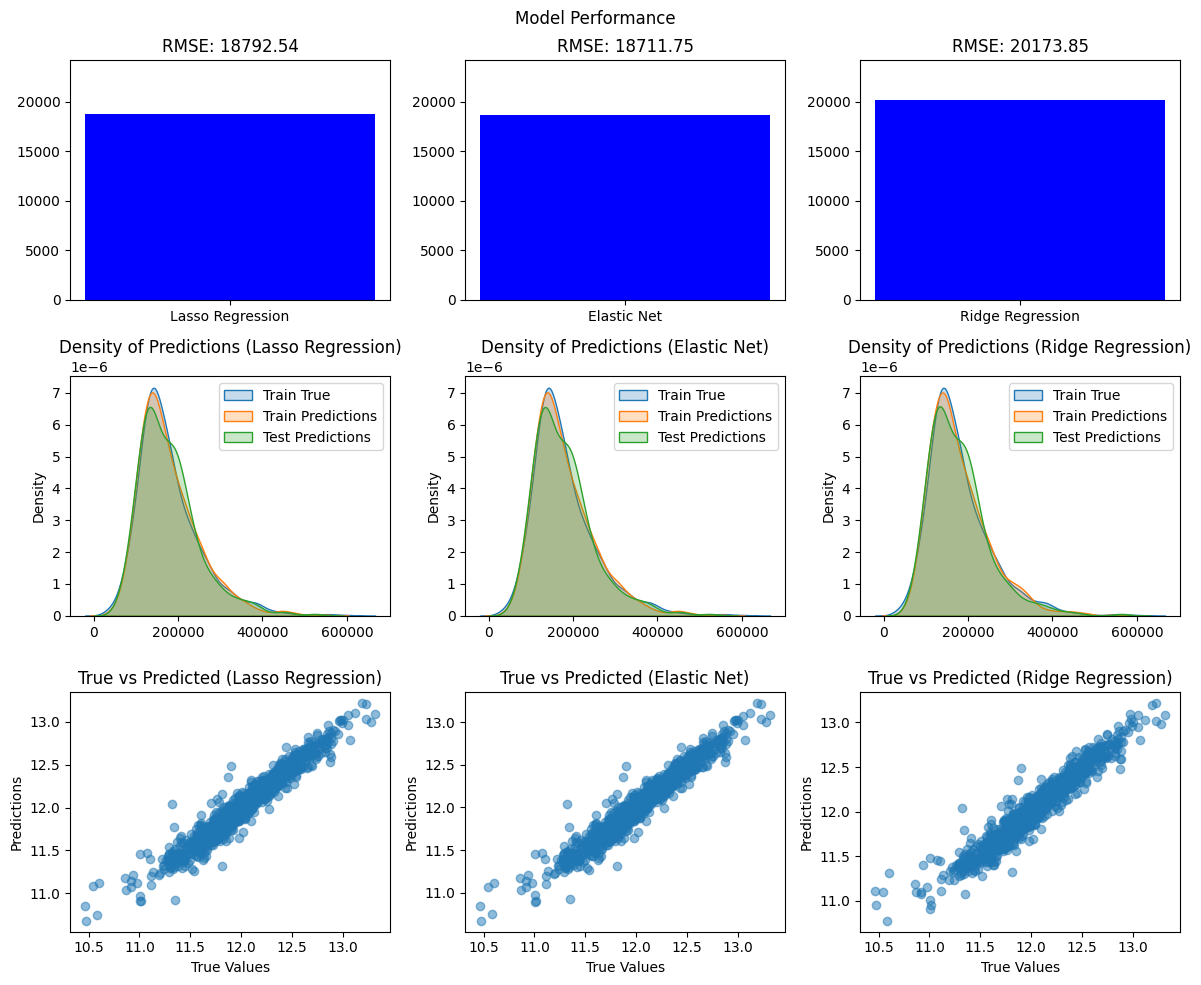

Лучший алгоритм: Elastic Net с RMSE 18711.75
Файл submission.csv сохранён!


In [6]:
# V4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from scipy.stats import skew

trainDf = pd.read_csv('train_hw.csv')
testDf = pd.read_csv('test_hw.csv')

trainID = trainDf['Id']
testID = testDf['Id']

trainDf.drop("Id", axis = 1, inplace = True)
testDf.drop("Id", axis = 1, inplace = True)

trainDf = trainDf.drop(trainDf[(trainDf['GrLivArea']>4000)].index)

trainDf["SalePrice"] = np.log1p(trainDf["SalePrice"])

ntrain = trainDf.shape[0]
ntest = testDf.shape[0]
Ytrain = trainDf.SalePrice.values
allData = pd.concat((trainDf, testDf)).reset_index(drop=True)
allData.drop(['SalePrice'], axis=1, inplace=True)

allData['PoolQC'] = allData['PoolQC'].fillna('None')
allData['MiscFeature'] = allData['MiscFeature'].fillna('None')
allData['Alley'] = allData['Alley'].fillna('None')
allData['Fence'] = allData['Fence'].fillna('None')
allData['FireplaceQu'] = allData['FireplaceQu'].fillna('None')

allData['LotFrontage'] = allData.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    allData[col] = allData[col].fillna('None')
allData['GarageYrBlt'] = allData['GarageYrBlt'].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2'):
    allData[col] = allData[col].fillna('None')

allData['MasVnrType'] = allData['MasVnrType'].fillna('None')
allData['MasVnrArea'] = allData['MasVnrArea'].fillna(0)

allData['Electrical'] = allData['Electrical'].fillna(allData['Electrical'].mode()[0])

allData['MSSubClass'] = allData['MSSubClass'].apply(str)
allData['OverallCond'] = allData['OverallCond'].astype(str)
allData['YrSold'] = allData['YrSold'].astype(str)
allData['MoSold'] = allData['MoSold'].astype(str)

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for col in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(allData[col].values)) 
    allData[col] = lbl.transform(list(allData[col].values))

allData['TotalSF'] = allData['TotalBsmtSF'] + allData['1stFlrSF'] + allData['2ndFlrSF']

numCols = allData.dtypes[allData.dtypes != "object"].index
skewedCols = allData[numCols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewedCols})
skewness = skewness[abs(skewness) > 0.75].dropna()

from scipy.special import boxcox1p
skewedFeatures = skewness.index

for feat in skewedFeatures:
    skewValue = skewness.loc[feat, "Skew"]

    if abs(skewValue) > 2: 
        lam = 0.05  
    elif abs(skewValue) > 0.75:
        lam = 0.15

    allData[feat] = boxcox1p(allData[feat], lam)

allData = pd.get_dummies(allData)
print(allData.shape)

trainDf = allData[:ntrain]
testDf = allData[ntrain:]

def rmsle_cv(model):
    kf = KFold(n_splits = 5, shuffle=True, random_state=42)
    rmse= np.sqrt(-cross_val_score(model, trainDf.values, Ytrain, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

models = {
    #"Linear Regression": make_pipeline(RobustScaler(), LinearRegression()),
    "Lasso Regression": make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=42)),
    "Elastic Net": make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=42)),
    "Ridge Regression": Ridge(alpha=100, random_state=42),
    #"XGBoost Regressor": XGBRegressor()
}
results = {}

for name, model in models.items():
    score = rmsle_cv(model)
    print(f"{name} score: {score.mean():.4f} ({score.std():.4f})")
print()

fig, axes = plt.subplots(3, len(models), figsize=(len(models)*4, 10))
fig.suptitle('Model Performance')

for i, (name, model) in enumerate(models.items()):
    model.fit(trainDf.values, Ytrain)
    YtrainPred = model.predict(trainDf.values)
    YtestPred = model.predict(testDf.values)

    YtrainPredExp = np.expm1(YtrainPred)
    YtrainExp = np.expm1(Ytrain)
    YtestPredExp = np.expm1(YtestPred)

    trainRmse = np.sqrt(mean_squared_error(YtrainExp, YtrainPredExp))
    logRMSE = np.log1p(trainRmse)
    results[name] = trainRmse
    print(f'RMSE ({name}) на тренировочном наборе: {trainRmse:.2f} (log: {logRMSE:.2f})')

    sns.kdeplot(YtrainExp, label='Train True', fill=True, ax=axes[1, i])
    sns.kdeplot(YtrainPredExp, label='Train Predictions', fill=True, ax=axes[1, i])
    sns.kdeplot(YtestPredExp, label='Test Predictions', fill=True, ax=axes[1, i])
    axes[1, i].set_title(f'Density of Predictions ({name})')
    axes[1, i].legend()

    axes[2, i].scatter(Ytrain, YtrainPred, alpha=0.5)
    axes[2, i].set_xlabel('True Values')
    axes[2, i].set_ylabel('Predictions')
    axes[2, i].set_title(f'True vs Predicted ({name})')

for i, (name, score) in enumerate(results.items()):
    axes[0, i].bar(name, score, color='blue')
    axes[0, i].set_title(f'RMSE: {score:.2f}')
    axes[0, i].set_ylim(0, max(results.values()) * 1.2)

plt.tight_layout()
plt.show()

bestModelName = min(results, key=results.get)
finalModel = models[bestModelName].fit(trainDf.values, Ytrain)
yTestPredFinal = np.expm1(finalModel.predict(testDf.values))

submission = pd.DataFrame({
    'Id': testID,
    'SalePrice': yTestPredFinal
})
submission.to_csv('submission.csv', index=False)

print(f"Лучший алгоритм: {bestModelName} с RMSE {results[bestModelName]:.2f}")
print("Файл submission.csv сохранён!")

(1452, 222)
Lasso Regression score: 0.1149 (0.0141)
Elastic Net score: 0.1149 (0.0141)

RMSE (Lasso Regression) на тренировочном наборе: 18766.74 (log: 9.84)
RMSE (Elastic Net) на тренировочном наборе: 18690.67 (log: 9.84)


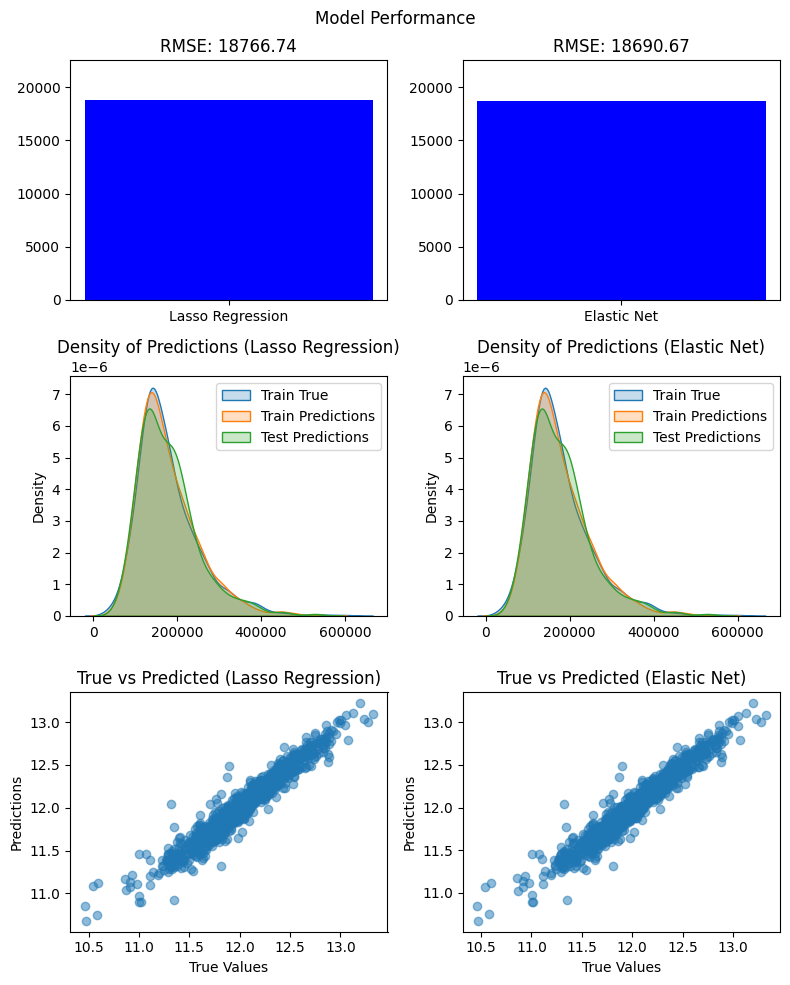

Лучший алгоритм: Elastic Net с RMSE 18690.67
Файл submission.csv сохранён!


In [7]:
# V5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBRegressor
from scipy.stats import skew

trainDf = pd.read_csv('train_hw.csv')
testDf = pd.read_csv('test_hw.csv')

trainID = trainDf['Id']
testID = testDf['Id']

trainDf.drop('Id', axis = 1, inplace = True)
testDf.drop('Id', axis = 1, inplace = True)

trainDf = trainDf.drop(trainDf[(trainDf['GrLivArea']>4000)].index)
trainDf = trainDf.drop(trainDf[(trainDf['TotalBsmtSF']>2750)].index)
trainDf = trainDf.drop(trainDf[(trainDf['1stFlrSF']>2750)].index)

trainDf['SalePrice'] = np.log1p(trainDf['SalePrice'])

ntrain = trainDf.shape[0]
ntest = testDf.shape[0]
Ytrain = trainDf['SalePrice'].values
allData = pd.concat((trainDf, testDf)).reset_index(drop=True)
allData.drop(['SalePrice'], axis=1, inplace=True)

allData['PoolQC'] = allData['PoolQC'].fillna('None')
allData['MiscFeature'] = allData['MiscFeature'].fillna('None')
allData['Alley'] = allData['Alley'].fillna('None')
allData['Fence'] = allData['Fence'].fillna('None')
allData['FireplaceQu'] = allData['FireplaceQu'].fillna('None')

allData['LotFrontage'] = allData.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    allData[col] = allData[col].fillna('None')
allData['GarageYrBlt'] = allData['GarageYrBlt'].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2'):
    allData[col] = allData[col].fillna('None')

allData['MasVnrType'] = allData['MasVnrType'].fillna('None')
allData['MasVnrArea'] = allData['MasVnrArea'].fillna(0)

allData['Electrical'] = allData['Electrical'].fillna(allData['Electrical'].mode()[0])


allData['MSSubClass'] = allData['MSSubClass'].apply(str)
allData['OverallCond'] = allData['OverallCond'].astype(str)
allData['YrSold'] = allData['YrSold'].astype(str)
allData['MoSold'] = allData['MoSold'].astype(str)

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for col in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(allData[col].values)) 
    allData[col] = lbl.transform(list(allData[col].values))

allData['TotalSF'] = allData['TotalBsmtSF'] + allData['1stFlrSF'] + allData['2ndFlrSF']

numCols = allData.select_dtypes(exclude=['object']).columns
skewedCols = allData[numCols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewedCols})
skewness = skewness[abs(skewness) > 0.75].dropna()

from scipy.special import boxcox1p
skewedFeatures = skewness.index

for feat in skewedFeatures:
    skewValue = skewness.loc[feat, 'Skew']

    if abs(skewValue) > 2: 
        lam = 0.05  
    elif abs(skewValue) > 0.75:
        lam = 0.15

    allData[feat] = boxcox1p(allData[feat], lam)

allData = pd.get_dummies(allData)
print(allData.shape)

trainDf = allData[:ntrain]
testDf = allData[ntrain:]

def rmsle_cv(model):
    kf = KFold(n_splits = 5, shuffle=True, random_state=42)
    rmse= np.sqrt(-cross_val_score(model, trainDf.values, Ytrain, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

models = {
    #"Linear Regression": make_pipeline(RobustScaler(), LinearRegression()),
    "Lasso Regression": make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=42)),
    "Elastic Net": make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=42)),
    #"Ridge Regression": make_pipeline(RobustScaler(), Ridge(alpha=0.1, random_state=42)),
    #"XGBoost Regressor": XGBRegressor()
}
results = {}

for name, model in models.items():
    score = rmsle_cv(model)
    print(f"{name} score: {score.mean():.4f} ({score.std():.4f})")
print()

fig, axes = plt.subplots(3, len(models), figsize=(len(models)*4, 10))
fig.suptitle('Model Performance')

for i, (name, model) in enumerate(models.items()):
    model.fit(trainDf.values, Ytrain)
    YtrainPred = model.predict(trainDf.values)
    YtestPred = model.predict(testDf.values)

    YtrainPredExp = np.expm1(YtrainPred)
    YtrainExp = np.expm1(Ytrain)
    YtestPredExp = np.expm1(YtestPred)

    trainRMSE = np.sqrt(mean_squared_error(YtrainExp, YtrainPredExp))
    logRMSE = np.log1p(trainRMSE)
    results[name] = trainRMSE
    print(f'RMSE ({name}) на тренировочном наборе: {trainRMSE:.2f} (log: {logRMSE:.2f})')

    sns.kdeplot(YtrainExp, label='Train True', fill=True, ax=axes[1, i])
    sns.kdeplot(YtrainPredExp, label='Train Predictions', fill=True, ax=axes[1, i])
    sns.kdeplot(YtestPredExp, label='Test Predictions', fill=True, ax=axes[1, i])
    axes[1, i].set_title(f'Density of Predictions ({name})')
    axes[1, i].legend()

    axes[2, i].scatter(Ytrain, YtrainPred, alpha=0.5)
    axes[2, i].set_xlabel('True Values')
    axes[2, i].set_ylabel('Predictions')
    axes[2, i].set_title(f'True vs Predicted ({name})')

for i, (name, score) in enumerate(results.items()):
    axes[0, i].bar(name, score, color='blue')
    axes[0, i].set_title(f'RMSE: {score:.2f}')
    axes[0, i].set_ylim(0, max(results.values()) * 1.2)

plt.tight_layout()
plt.show()

bestModelName = min(results, key=results.get)
finalModel = models[bestModelName].fit(trainDf.values, Ytrain)
YtestPredFinal = np.expm1(finalModel.predict(testDf.values))

submission = pd.DataFrame({
    'Id': testID,
    'SalePrice': YtestPredFinal
})
submission.to_csv('submission.csv', index=False)

print(f"Лучший алгоритм: {bestModelName} с RMSE {results[bestModelName]:.2f}")
print("Файл submission.csv сохранён!")